<a href="https://colab.research.google.com/github/imranhossian607/thesis2.0/blob/main/inceptionsv3_Alexnet_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow
import scipy
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))


# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

Num GPUs Available:  1


In [ ]:
!pip install split-folders


In [ ]:
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split the dataset into train, validation, and test sets
input_folder = '/content/drive/MyDrive/Dataset'
output_folder = 'output'

splitfolders.ratio(input_folder, output=output_folder, seed=1345, ratio=(0.7, 0.15, 0.15))

# Define data augmentation parameters
WIDTH,HEIGHT=224,224

train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.2,          # Zoom in/out by a maximum of 20%
                                   horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

# Define the directories for your training, validation, and test sets
train_dir = os.path.join(output_folder, 'train')
valid_dir = os.path.join(output_folder, 'val')
test_dir = os.path.join(output_folder, 'test')

# Apply data augmentation to the training dataset
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (WIDTH,HEIGHT),
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)


# No augmentation for validation and test datasets
valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(WIDTH,HEIGHT),   # Adjust the target size as needed
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(WIDTH,HEIGHT),   # Adjust the target size as needed
    color_mode = "rgb",
    batch_size = 64,
    interpolation = "bicubic" ,
    shuffle = True ,
    class_mode='categorical'  # Change to appropriate mode for your dataset
)


Copying files: 6400 files [00:28, 228.51 files/s]


Found 4479 images belonging to 4 classes.
Found 959 images belonging to 4 classes.
Found 962 images belonging to 4 classes.


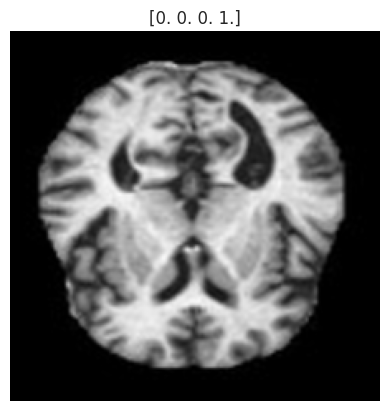

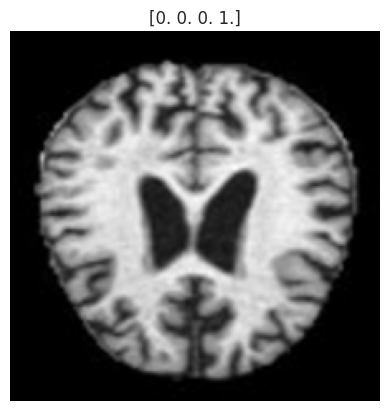

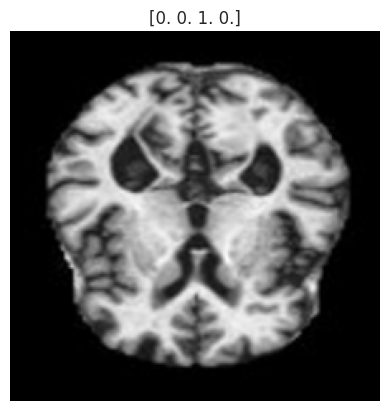

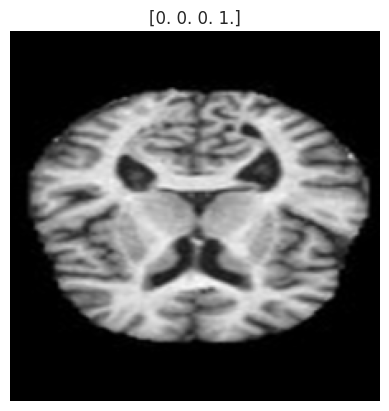

In [ ]:
batch_1_img = train_data[0]
for i in range(0,4):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

#InceptionV3

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Dropout

# Load the pre-trained InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(HEIGHT, WIDTH, 3))

# Create a new model by adding custom layers on top of InceptionV3
model = keras.models.Sequential()

# Add the pre-trained InceptionV3 model
model.add(base_model)

# Add custom fully connected layers on top of InceptionV3
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Define early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 4)                 260       
                                                                 
Total params: 28365028 (108.20 MB)
Trainable params: 2

In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

['loss', 'accuracy', 'recall_3', 'precision_3', 'auc_3', 'val_loss', 'val_accuracy', 'val_recall_3', 'val_precision_3', 'val_auc_3'] 



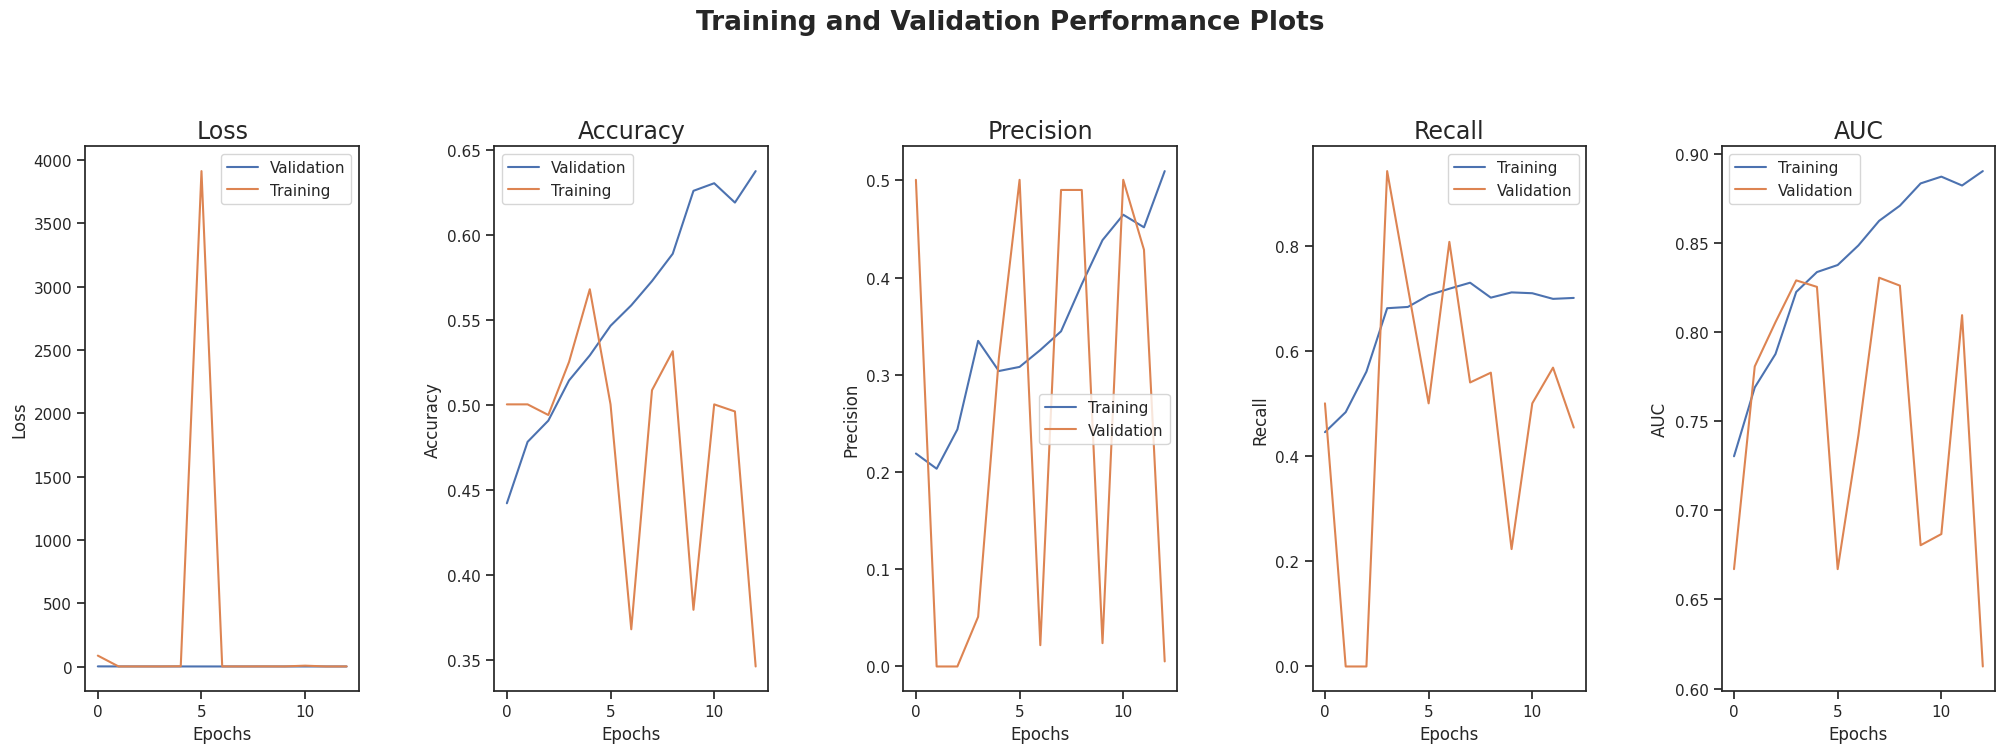

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

16/16 [==============================] - 4s 207ms/step - loss: 1.0448 - accuracy: 0.5187 - recall_3: 0.0000e+00 - precision_3: 0.0000e+00 - auc_3: 0.8136


ZeroDivisionError: ignored

#Alexnet

In [ ]:
import tensorflow as tf
from tensorflow import keras

input_shape = (WIDTH, HEIGHT, 3)

# Define your AlexNet-like model
model = keras.models.Sequential()

# Layer 1
model.add(keras.layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape, padding='valid'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 2
model.add(keras.layers.Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# Layer 3
model.add(keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same'))

# Layer 4
model.add(keras.layers.Conv2D(384, (3, 3), activation='relu', padding='same'))

# Layer 5
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(keras.layers.Flatten())

# Fully Connected Layers
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dropout(0.5))

# Output Layer
model.add(keras.layers.Dense(4, activation='softmax'))

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=["accuracy", tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()]
)

# Early stopping callback
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
model_history = model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=[callback])


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_95 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_96 (Conv2D)          (None, 12, 12, 384)       885120    
                                                                 
 conv2d_97 (Conv2D)          (None, 12, 12, 384)      

In [ ]:
metricsEval = list(model_history.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(model_history.history)
historyDF.head()
historyDF.to_csv('mycsvfile.csv',index=False)

['loss', 'accuracy', 'recall_1', 'precision_1', 'auc_1', 'val_loss', 'val_accuracy', 'val_recall_1', 'val_precision_1', 'val_auc_1'] 



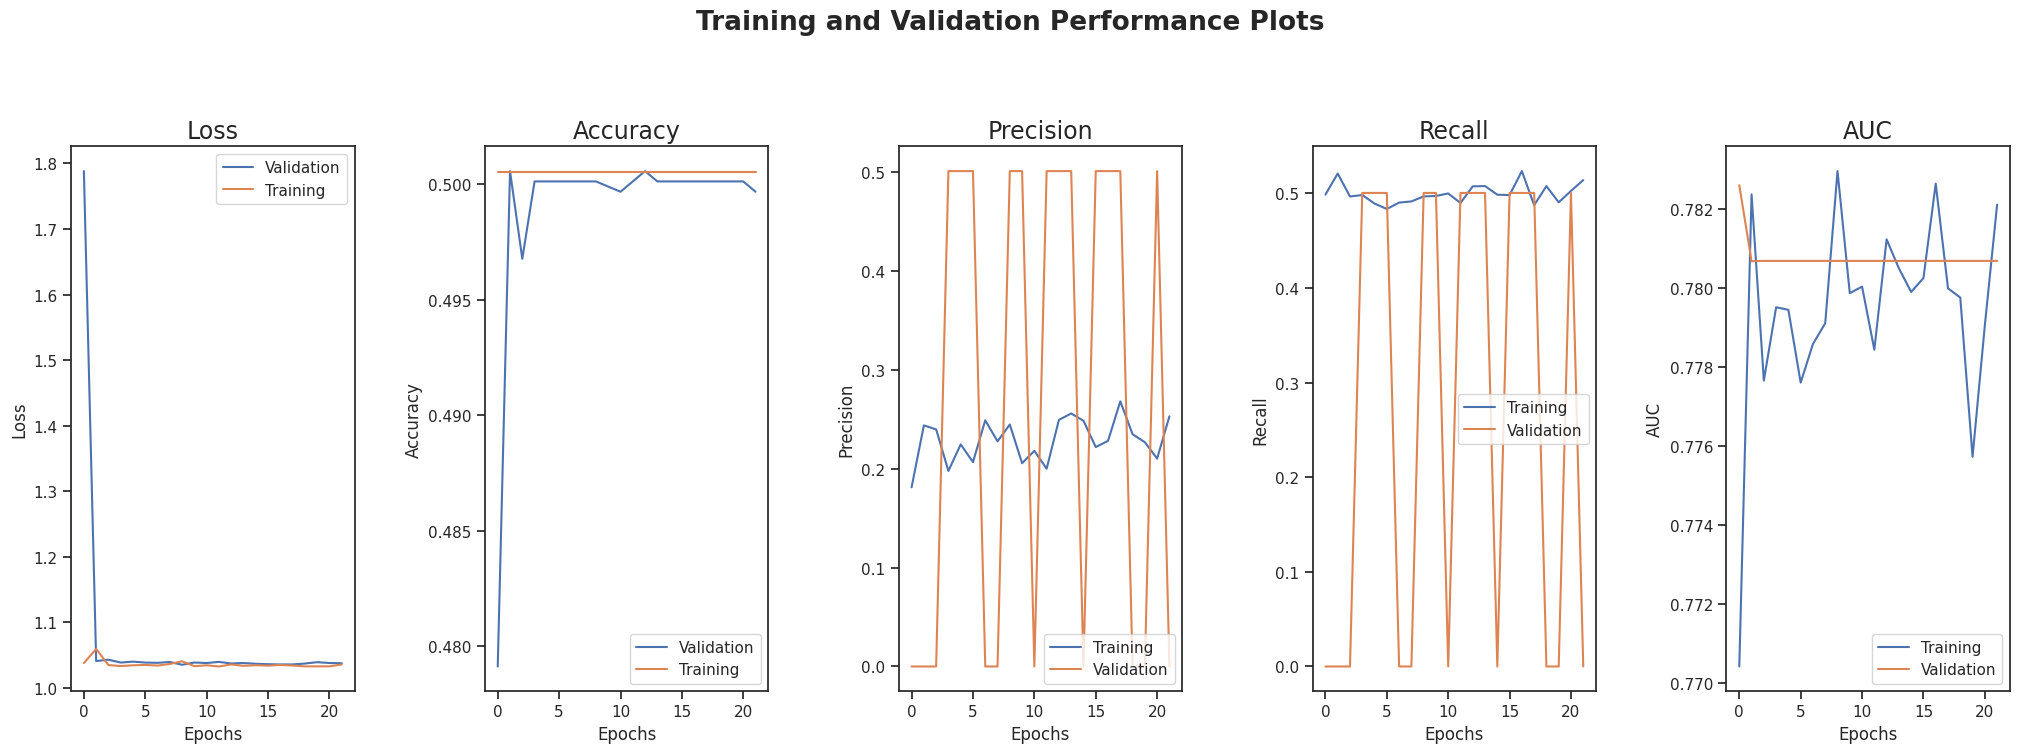

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axarr = plt.subplots(1, 5, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale=1)

# Modify the code to create the lineplots on the same row
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[0]], ax=axarr[0], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[5]], ax=axarr[0], label="Training")
axarr[0].set_ylabel('Loss')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[1]], ax=axarr[1], label="Validation")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[6]], ax=axarr[1], label="Training")
axarr[1].set_ylabel('Accuracy')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[2]], ax=axarr[2], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[7]], ax=axarr[2], label="Validation")
axarr[2].set_ylabel('Precision')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[3]], ax=axarr[3], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[8]], ax=axarr[3], label="Validation")
axarr[3].set_ylabel('Recall')

ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[4]], ax=axarr[4], label="Training")
ax = sns.lineplot(x=historyDF.index, y=model_history.history[metricsEval[9]], ax=axarr[4], label="Validation")
axarr[4].set_ylabel('AUC')

# Modify the titles and labels as needed
axarr[0].set_title('Loss', fontsize=17)
axarr[1].set_title('Accuracy', fontsize=17)
axarr[2].set_title('Precision', fontsize=17)
axarr[3].set_title('Recall', fontsize=17)
axarr[4].set_title('AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Validation Performance Plots', fontsize=19, weight='bold')
fig.tight_layout(pad=3.0)
plt.savefig("trainingandval.png", dpi=1080)
plt.show()


In [ ]:
# Assuming you have test_data and test_labels for your test set
test_metrics = model.evaluate(test_data)

test_accuracy = test_metrics[1]
test_precision = test_metrics[3]
test_recall = test_metrics[2]
test_auc = test_metrics[4]

# Calculate F1 score
test_f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test AUC:", test_auc)
print("Test F1 Score:", test_f1_score)

16/16 [==============================] - 3s 192ms/step - loss: 1.0414 - accuracy: 0.4990 - recall_1: 0.4990 - precision_1: 0.4990 - auc_1: 0.7786
Test Accuracy: 0.4989604949951172
Test Precision: 0.4989604949951172
Test Recall: 0.4989604949951172
Test AUC: 0.7785863280296326
Test F1 Score: 0.4989604949951172
